<a href="https://colab.research.google.com/github/cplacanica/FINAL-THESIS/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis

In [1]:
import altair as alt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('DB_FINAL.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'DB_FINAL.csv'

In [ ]:
df

In [ ]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

### Indicator statistics

In [ ]:
# Compute statistics for each indicator
indicator_stats = df.groupby("Indicator Name")["Indicator Value"].describe()
# Save the statistics to a CSV file
indicator_stats.to_csv("indicator_statistics.csv")
# Display the first few rows
print(indicator_stats.head())

In [ ]:
null_counts = df.isna().sum()

for i, j in enumerate(range(len(null_counts))):
  if null_counts[i].sum() > 0:
      print(f'The Variable `{df.columns[j]}` has {null_counts[i]} null values')

In [ ]:
df.dtypes

### Show how many non-null values each year has

In [ ]:
# Filter the data to include only non-null values in the 'Value' column
filtered_data = df.dropna(subset=['Indicator Value'])

# Count the number of non-null 'Value' entries for each year
value_counts_per_year = filtered_data['Year'].value_counts().sort_index()
value_counts_per_year

In [ ]:
# Create the plot of non-null 'Value' entries for each year
plt.figure(figsize=(20, 10))
sns.barplot(x=value_counts_per_year.index, y=value_counts_per_year.values, palette='viridis')

plt.xlabel("Year")
plt.ylabel("Count of Non-null Values")
plt.title("Distribution of Non-null Values per Year")
plt.xticks(rotation=90)
plt.show()

In [ ]:
unique_indicator_codes = df['Indicator Code'].unique()
unique_indicator_codes_sorted = sorted(unique_indicator_codes)

# Print or display the DataFrame
print(unique_indicator_codes_sorted)

### ADD VARIABLE GENDER

In [ ]:
# Function to create the GENDER column
def classify_gender(code):
    if 'FE' in code:
        return 'Female'
    elif 'MA' in code:
        return 'Male'
    else:
        return 'Total'

df['Gender'] = df['Indicator Code'].apply(classify_gender)

In [ ]:
unique_pairs = df[['Indicator Code', 'Gender']].drop_duplicates()
unique_pairs

In [ ]:
df

## DATA ANALYSIS

### Population Statistics

The indicators in the population statistics clusters are:
- Population growth (annual %)
- Population density (people per sq. km of land area)
- Population in urban agglomerations of more than 1 million (% of total population)
- Population in the largest city (% of urban population)
- Population, total
- Population, female
- Population, male
- Rural population growth (annual %)
- Urban population growth (annual %)
- Urban population (% of total population)

In [ ]:
# choosing the color palette for the countries
country_colors = {
    "China": "#87bc45",  # orange
    "India": "#d45087",  # pink
    "European Union": "#003f5c"  # blue
}

### Total Population

In [ ]:
# Group by Year and Country, summing the Indicator Value
grouped_df = df[df['Indicator Name'] == 'Population, total'].groupby(['Year', 'Country'])['Indicator Value'].sum().reset_index()

# Create the stacked bar chart
stacked_bar_chart = alt.Chart(grouped_df).mark_bar(cornerRadiusTopLeft=3, cornerRadiusTopRight=3, opacity=0.7).encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('sum(Indicator Value):Q', title='Total Population').stack(None),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('sum(Indicator Value):Q', title='Population')
    ]
).properties(
    title='Total Population by Year and Country',
    width=800,
    height=600
).interactive()

# Display the stacked bar chart
stacked_bar_chart

### Total Population Growth

In [ ]:
female_population_indicator = "Population, female"
male_population_indicator = "Population, male"

df_tot_pop = df[df["Indicator Name"].isin([female_population_indicator, male_population_indicator])]

# Aggregate population by year
df_pop_pivot = df_tot_pop.groupby(["Year", "Indicator Name"])["Indicator Value"].sum().reset_index()

# Create stacked bar chart
bar_chart = alt.Chart(df_pop_pivot).mark_bar().encode(
    x=alt.X("Year:O", title="Year", axis=alt.Axis(values=[year for year in range(df['Year'].min(), df['Year'].max() + 1, 5)], labelAngle=-45)),
    y=alt.Y("Indicator Value:Q", title="Total Population"),
    color=alt.Color("Indicator Name:N", title="Population Type"),
    tooltip=["Year", "Indicator Name", "Indicator Value"]
).properties(
    title="Stacked Bar Chart of Female and Male Population Over the Years",
    width=400,
    height=250
)

# Create line chart
line_chart = alt.Chart(df_pop_pivot).mark_line().encode(
    x=alt.X("Year:O", title="Year", axis=alt.Axis(values=[year for year in range(df['Year'].min(), df['Year'].max() + 1, 5)], labelAngle=-45)),
    y=alt.Y("Indicator Value:Q", title="Population"),
    color=alt.Color("Indicator Name:N", title="Population Type"),
    tooltip=["Year", "Indicator Name", "Indicator Value"]
).properties(
    title="Line Graph of Female and Male Population Over the Years",
    width=400,
    height=250
)

combined_chart = alt.hconcat(bar_chart, line_chart)
combined_chart.show()

### Annual Population Growth

In [ ]:
# Define a selection that chooses the country to highlight
legend_selection = alt.selection_point(fields=['Country'], bind='legend')

# Create the chart with interactive legend
population_growth_chart = alt.Chart(df[df['Indicator Name'] == 'Population growth (annual %)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q', title='Population Growth (%)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    opacity=alt.condition(legend_selection, alt.value(1), alt.value(0.1)),
    tooltip=['Year', 'Country', 'Indicator Value']
).add_params(
    legend_selection
)
# Add zero line
zero_line = alt.Chart(df[df['Indicator Name'] == 'Population growth (annual %)']).mark_rule(color='black').encode(
    y='a:Q'
).transform_calculate(
    a="0"
)

# Combine the population chart with the zero line
final_chart = alt.layer(population_growth_chart, zero_line).properties(
    title='Annual Population Growth by Country',
    width=800,
    height=600
)

final_chart

### Urban vs. Rural Population Growth

In [ ]:
urban_growth_chart = alt.Chart(df[df['Indicator Name'] == 'Urban population growth (annual %)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(df['Year'].min(), df['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Urban Population Growth by Country',
    width=500,
    height=300
)

rural_growth_chart = alt.Chart(df[df['Indicator Name'] == 'Rural population growth (annual %)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(df['Year'].min(), df['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Rural Population Growth by Country',
    width=500,
    height=300
)

# Display both charts
(urban_growth_chart | rural_growth_chart).display()

### Rural Growth Rate per Year

In [ ]:
# Create a selection dropdown for countries
country_selection = alt.selection_point(
    fields=['Country'],
    bind=alt.binding_select(options=sorted(df[df['Indicator Name'] == 'Rural population growth (annual %)']['Country'].unique()), name='Select Country'),
)

# Create the chart
chart = alt.Chart(df[df['Indicator Name'] == 'Rural population growth (annual %)']).mark_bar().encode(
    x='Year:O',
    y='Indicator Value:Q',
    color=alt.condition(
        alt.datum['Indicator Value'] < 0,
        alt.value('red'),
        alt.value('steelblue')
    ),
    tooltip=['Country', 'Year', 'Indicator Value']
).add_params(
    country_selection
).transform_filter(
    country_selection
).properties(
    width=800,
    height=600,
    title="Rural Growth Rate by Year"
)

chart

In [ ]:
country_selection = alt.selection_point(
    fields=['Country'],
    bind='legend',
    name='Highlight Country'
)

urban_population_chart = alt.Chart(df[df['Indicator Name'] == 'Urban population (% of total population)']).mark_line().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q', title='Urban Population (% of total population)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'), scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    opacity=alt.condition(country_selection, alt.value(1), alt.value(0.15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Indicator Value:Q', title='Urban Population (% of total population)'),
        alt.Tooltip('Country:N', title='Country')
    ]
).add_params(
    country_selection
).properties(
    width=800,
    height=300,
    title='Urban Population (% of total population) Over Time'
)
urban_population_chart.show()

### Population in urban agglomerations of more than 1 million (% of total population)

In [ ]:
country_selection = alt.selection_point(
    fields=['Country'],
    bind='legend',
    name='Highlight Country'
)

urban_population_chart = alt.Chart(df[df['Indicator Name'] == 'Population in urban agglomerations of more than 1 million (% of total population)']).mark_line().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q',
            title='Population in urban agglomerations of more than 1 million (% of total population)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'), scale=alt.Scale(domain=list(country_colors.keys()),
                                                                                     range=list(
                                                                                         country_colors.values()))),
    opacity=alt.condition(country_selection, alt.value(1), alt.value(0.15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Indicator Value:Q',
                    title='Population in urban agglomerations of more than 1 million (% of total population)'),
        alt.Tooltip('Country:N', title='Country')
    ]
).add_params(
    country_selection
).properties(
    width=800,
    height=300,
    title='Population in urban agglomerations of more than 1 million (% of total population) Over Time'
)

# Display the chart
urban_population_chart

#### Population in the largest city (% of urban population)

In [ ]:
country_selection = alt.selection_point(
    fields=['Country'],
    bind='legend',
    name='Highlight Country'
)

largest_city_chart = alt.Chart(df[df['Indicator Name'] == 'Population in the largest city (% of urban population)']).mark_line().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q',
            title='Population in the largest city (% of urban population)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'), scale=alt.Scale(domain=list(country_colors.keys()),
                                                                                     range=list(
                                                                                         country_colors.values()))),
    opacity=alt.condition(country_selection, alt.value(1), alt.value(0.15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Indicator Value:Q',
                    title='Population in the largest city (% of urban population)'),
        alt.Tooltip('Country:N', title='Country')
    ]
).add_params(
    country_selection
).properties(
    width=800,
    height=300,
    title='Population in the largest city (% of urban population) Over Time'
)

# Display the chart
largest_city_chart

#### Population density (people per sq. km of land area)

In [ ]:
country_selection = alt.selection_point(
    fields=['Country'],
    bind='legend',
    name='Highlight Country'
)

population_density_chart = alt.Chart(df[df['Indicator Name'] == 'Population density (people per sq. km of land area)']).mark_line().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q',
            title='Population density (people per sq. km of land area)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'), scale=alt.Scale(domain=list(country_colors.keys()),
                                                                                     range=list(
                                                                                         country_colors.values()))),
    opacity=alt.condition(country_selection, alt.value(1), alt.value(0.15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Indicator Value:Q',
                    title='Population density (people per sq. km of land area)'),
        alt.Tooltip('Country:N', title='Country')
    ]
).add_params(
    country_selection
).properties(
    width=800,
    height=300,
    title='Population density (people per sq. km of land area) Over Time'
)

# Display the chart
population_density_chart

### Population: Male vs. Female

In [ ]:
# Create a dropdown selection for the country
country_dropdown = alt.binding_select(options=list(df[df['Indicator Name'].isin(['Population, female', 'Population, male'])]['Country'].unique()), name="Select Country: ")
country_selection = alt.selection_point(fields=['Country'], bind=country_dropdown, name="CountrySelection")

# Create the interactive stacked bar chart
chart = alt.Chart(df[df['Indicator Name'].isin(['Population, female', 'Population, male'])]).mark_bar().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('sum(Indicator Value):Q', title='Population'),
    color=alt.Color('Indicator Name:N', title='Gender',
                    scale=alt.Scale(domain=['Population, female', 'Population, male'],
                                    range=['#d45087', '#003f5c'])),
    tooltip=['Year', 'Country', 'Indicator Name', 'sum(Indicator Value):Q']
).transform_filter(
    country_selection
).properties(
    title='Total Population by Gender',
    width=800,
    height=700
).add_params(
    country_selection
)

# Display the chart
chart.show()

## Correlations in Population Statistics

In [ ]:
indicators_population = [
    'Population growth (annual %)',
    'Population density (people per sq. km of land area)',
    'Population in urban agglomerations of more than 1 million (% of total population)',
    'Population in the largest city (% of urban population)',
    'Population, total',
    'Population, female',
    'Population, male',
    'Rural population growth (annual %)',
    'Urban population growth (annual %)',
    'Urban population (% of total population)'
]

# Filter the data for these specific indicators
population_data = df[df['Indicator Name'].isin(indicators_population)]

### Create Pivot Table

In [ ]:
pivot_df = population_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

print(pivot_df)

### Correlation in all Countries

#### Spearman Correlation

In [ ]:
correlation_matrix_sp = pivot_df.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="spearman")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_sp, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Spearman Correlation - All Countries', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Pearson's Correlation

In [ ]:
correlation_matrix_pe = pivot_df.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_pe, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0)
plt.title('Pearson Correlation - All Countries', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Data Distribution - Boxplots

In [ ]:
# Create the plot
plt.figure(figsize=(18, 8))
sns.set_theme(style="whitegrid")

# Create the boxplot
boxplot = sns.boxplot(
    data=population_data[~population_data['Indicator Name'].isin(['Population, female', 'Population, total', 'Population, male', 'Population density (people per sq. km of land area)'])],
    x='Indicator Name',
    y='Indicator Value',
    hue='Country',
    palette=country_colors,
    linewidth=1.5,
    fliersize=3
)

# Enhance visual aesthetics
boxplot.set_title('Indicator-wise Boxplot of Percentages by Country', fontsize=20, weight='bold')
boxplot.set_xlabel('Indicators', fontsize=14, weight='bold')
boxplot.set_ylabel('Percentage (%)', fontsize=14, weight='bold')
boxplot.tick_params(axis='x', rotation=30, labelsize=12)
boxplot.tick_params(axis='y', labelsize=12)
boxplot.legend(title='Country', fontsize=12, title_fontsize=14)

# Add a tight grid for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Data Distribution - Boxplots

In [ ]:
# Create the plot
plt.figure(figsize=(18, 8))
sns.set_theme(style="whitegrid")

# Create the boxplot
boxplot = sns.boxplot(
    data=population_data[~population_data['Indicator Name'].isin(['Population, female', 'Population, total', 'Population, male',
                                                         'Population density (people per sq. km of land area)', 'Population in urban agglomerations of more than 1 million (% of total population)', 'Urban population (% of total population)'])],
    x='Indicator Name',
    y='Indicator Value',
    hue='Country',
    palette=country_colors,
    linewidth=1.5,
    fliersize=3  # Adjust outlier marker size
)

# Enhance visual aesthetics
boxplot.set_title('Indicator-wise Boxplot of Percentages by Country', fontsize=20, weight='bold')
boxplot.set_xlabel('Indicators', fontsize=14, weight='bold')
boxplot.set_ylabel('Percentage (%)', fontsize=14, weight='bold')
boxplot.tick_params(axis='x', rotation=0, labelsize=12)  # Rotated labels for better readability
boxplot.tick_params(axis='y', labelsize=12)
boxplot.legend(title='Country', fontsize=12, title_fontsize=14)

# Add a tight grid for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Create the plot
plt.figure(figsize=(18, 8))  # Adjusted for wider layout
sns.set_theme(style="whitegrid")

# Create the boxplot
boxplot = sns.boxplot(
    data=population_data[population_data['Indicator Name'].isin(['Population in urban agglomerations of more than 1 million (% of total population)', 'Urban population (% of total population)'])],
    x='Indicator Name',
    y='Indicator Value',
    hue='Country',
    palette=country_colors,
    linewidth=1.5,
    fliersize=3  # Adjust outlier marker size
)

# Enhance visual aesthetics
boxplot.set_title('Indicator-wise Boxplot of Percentages by Country', fontsize=20, weight='bold')
boxplot.set_xlabel('Indicators', fontsize=14, weight='bold')
boxplot.set_ylabel('Percentage (%)', fontsize=14, weight='bold')
boxplot.tick_params(axis='x', rotation=0, labelsize=12)  # Rotated labels for better readability
boxplot.tick_params(axis='y', labelsize=12)
boxplot.legend(title='Country', fontsize=12, title_fontsize=14)

# Add a tight grid for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## Employment Statistics

Employment Indicators:
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)
Wage and salaried workers, male (% of male employment) (modeled ILO estimate)
Contributing family workers, female (% of female employment) (modeled ILO estimate)
Contributing family workers, male (% of male employment) (modeled ILO estimate)
Employers, female (% of female employment) (modeled ILO estimate)
Employers, male (% of male employment) (modeled ILO estimate)
Employment in agriculture (% of female employment) (modeled ILO estimate)
Employment in agriculture (% of male employment) (modeled ILO estimate)
Employment in industry (% of female employment) (modeled ILO estimate)
Employment in industry (% of male employment) (modeled ILO estimate)
Employment in services (% of female employment) (modeled ILO estimate)
Employment in services (% of male employment) (modeled ILO estimate)
Vulnerable employment, male (% of male employment) (modeled ILO estimate)
Vulnerable employment, female (% of female employment) (modeled ILO estimate)
Part time employment, female (% of total female employment)
Part time employment, male (% of total male employment)
Self-employed, female (% of female employment) (modeled ILO estimate)
Self-employed, male (% of male employment) (modeled ILO estimate)
Unemployment, female (% of female labor force) (modeled ILO estimate)
Unemployment, male (% of male labor force) (modeled ILO estimate)

In [ ]:
employment_indicators = [
    'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)',
    'Wage and salaried workers, male (% of male employment) (modeled ILO estimate)',
    'Contributing family workers, female (% of female employment) (modeled ILO estimate)',
    'Contributing family workers, male (% of male employment) (modeled ILO estimate)',
    'Employers, female (% of female employment) (modeled ILO estimate)',
    'Employers, male (% of male employment) (modeled ILO estimate)',
    'Employment in agriculture, female (% of female employment) (modeled ILO estimate)',
    'Employment in agriculture, male (% of male employment) (modeled ILO estimate)',
    'Employment in industry, female (% of female employment) (modeled ILO estimate)',
    'Employment in industry, male (% of male employment) (modeled ILO estimate)',
    'Employment in services, female (% of female employment) (modeled ILO estimate)',
    'Employment in services, male (% of male employment) (modeled ILO estimate)',
    'Vulnerable employment, male (% of male employment) (modeled ILO estimate)',
    'Vulnerable employment, female (% of female employment) (modeled ILO estimate)',
    'Part time employment, female (% of total female employment)',
    'Part time employment, male (% of total male employment)',
    'Self-employed, female (% of female employment) (modeled ILO estimate)',
    'Self-employed, male (% of male employment) (modeled ILO estimate)',
    'Unemployment, female (% of female labor force) (modeled ILO estimate)',
    'Unemployment, male (% of male labor force) (modeled ILO estimate)',
    'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)',
    'Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)',
    'Urban population (% of total population)'
]

# Filter the data for these specific indicators
emp_data = df[df['Indicator Name'].isin(employment_indicators)]

In [ ]:
# Strip the indicators from the "(modeled ILO estimate)" in order to improve the readibility of the charts
emp_data["Indicator Name"] = emp_data["Indicator Name"].str.replace(" (modeled ILO estimate)", "", regex=False)
print(emp_data["Indicator Name"].unique())

### Labour Force Participation Rate

In [ ]:
country_selection = alt.selection_point(
    fields=['Country'],
    bind='legend',
    name='Highlight Country'
)

In [ ]:
lab_force = emp_data[emp_data['Year'] > 1990]
lab_force_chart = alt.Chart(lab_force[lab_force['Indicator Name'] == 'Labor force participation rate, female (% of female population ages 15+)']).mark_line().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q',
            title='Labor force participation rate, female (% of female population ages 15+)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'), scale=alt.Scale(domain=list(country_colors.keys()),
                                                                                     range=list(
                                                                                         country_colors.values()))),
    opacity=alt.condition(country_selection, alt.value(1), alt.value(0.15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Indicator Value:Q',
                    title='Labor force participation rate, female (% of female population ages 15+)'),
        alt.Tooltip('Country:N', title='Country')
    ]
).add_params(
    country_selection
).properties(
    width=800,
    height=300,
    title='Female Labor Force Participation Rate'
)

# Display the chart
lab_force_chart

### Pyramid Chart of All Employment Statistics (gender comparison)

In [ ]:
# Step 1: Filter rows that contain "male" or "female" in the name
emp_data_cleaned = emp_data[emp_data["Indicator Name"].str.contains(r"\b(male|female)\b", case=False, regex=True)]

In [ ]:
# Clean the Indicator Name
def clean_indicator_name(indicator):
    if "youth" in indicator.lower():
        return "Unemployment, youth"
    else:
        # Remove gender-specific and retain the main part of the indicator
        return (
            indicator.replace("(% of female employment)", "(% of employment)")
            .replace("(% of male employment)", "(% of employment)")
            .replace(", male", "")
            .replace(", female", "")
            .replace(" female", "")
            .replace(" male", "")
            .replace("  ", " ")
            .strip()
        )

emp_data_cleaned["Indicator Name"] = emp_data_cleaned["Indicator Name"].apply(clean_indicator_name)

avg_df = emp_data_cleaned.groupby(["Indicator Name", "Gender", "Country"], as_index=False)["Indicator Value"].mean()

In [ ]:
emp_data_cleaned

In [ ]:
# Adjust female values to be negative for the pyramid chart
avg_df["Indicator Value"] = avg_df.apply(
    lambda row: -row["Indicator Value"] if row["Gender"] == "Female" else row["Indicator Value"], axis=1)

In [ ]:
country_dropdown = alt.binding_select(options=list(avg_df['Country'].unique()), name="Select Country: ")
country_selection = alt.selection_point(fields=['Country'], bind=country_dropdown, name="CountrySelection")

# Calculate height based on the number of indicators
unique_indicators = avg_df["Indicator Name"].nunique()
chart_height = max(10 * unique_indicators, 700)

In [ ]:
# Create the pyramid chart
base = alt.Chart(avg_df).mark_bar().encode(
    x=alt.X("Indicator Value:Q", title="Average Value (%)", axis=alt.Axis(format=".1f")),
    y=alt.Y("Indicator Name:N", title=None, sort="ascending"),
    color=alt.Color("Gender:N", scale=alt.Scale(domain=["Male", "Female"], range=["#003f5c", "#d45087"]), legend=alt.Legend(title="Gender")),
    tooltip=["Country", "Indicator Name", "Gender", "Indicator Value"]
).add_params(
    country_selection
).transform_filter(
    country_selection
).properties(
    width=750,
    height=500,
    title="Pyramid Chart of Employment Indicators by Gender"
)

# Add center axis line
rule = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(strokeDash=[5, 5]).encode(x='x:Q')

# Combine the bars and the center axis
chart = (base + rule).configure_axis(
    labelFontSize=12,
    titleFontSize=14,
    labelLimit=1000
).configure_title(
    fontSize=18,
    anchor="start"
)

chart.show()

### Distribution of the Employment Indicators

In [ ]:
# Create the plot
plt.figure(figsize=(18, 8))
sns.set_theme(style="whitegrid")

# Create the boxplot
boxplot = sns.boxplot(
    data=emp_data[emp_data['Indicator Name'].isin(['Employment in agriculture, female (% of female employment)',
                                                   'Employment in industry, female (% of female employment)',
                                                   'Employment in services, female (% of female employment)'])],
    x='Indicator Name',
    y='Indicator Value',
    hue='Country',
    palette=country_colors,
    linewidth=1.5,
    fliersize=3)  # Adjust outlier marker size

# Enhance visual aesthetics
boxplot.set_title('Indicator-wise Boxplot of Employment Sectors by Country', fontsize=16, fontweight="bold", pad=20)
boxplot.set_xlabel('Indicators', fontsize=14, weight='bold', labelpad=15)
boxplot.set_ylabel('Percentage (%)', fontsize=14, weight='bold')
boxplot.tick_params(axis='x', rotation=0, labelsize=12)
boxplot.tick_params(axis='y', labelsize=12)
boxplot.legend(title='Country', fontsize=12, title_fontsize=14)

# Add a tight grid for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Distribution of Vulnerable and Informal Employment

In [ ]:
# Create the plot
plt.figure(figsize=(18, 8))
sns.set_theme(style="whitegrid")

# Create the boxplot
boxplot = sns.boxplot(
    data=emp_data[emp_data['Indicator Name'].isin(['Contributing family workers, female (% of female employment)',
                                                   'Vulnerable employment, female (% of female employment)',
                                                   'Self-employed, female (% of female employment)'])],
    x='Indicator Name',
    y='Indicator Value',
    hue='Country',
    palette=country_colors,
    linewidth=1.5,
    fliersize=3)  # Adjust outlier marker size

# Enhance visual aesthetics
boxplot.set_title('Indicator-wise Boxplot of Female Vulnerable Employment by Country', fontsize=16, fontweight="bold", pad=20)
boxplot.set_xlabel('Indicators', fontsize=14, weight='bold', labelpad=15)
boxplot.set_ylabel('Percentage (%)', fontsize=14, weight='bold')
boxplot.tick_params(axis='x', rotation=0, labelsize=12)
boxplot.tick_params(axis='y', labelsize=12)
boxplot.legend(title='Country', fontsize=12, title_fontsize=14)

# Add a tight grid for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Create a selection for the countries
country_selection = alt.selection_point(fields=['Country'], bind='legend')
emp_sect_data = emp_data[emp_data['Indicator Name'].isin(['Employment in agriculture, female (% of female employment)',
                                                   'Employment in industry, female (% of female employment)',
                                                   'Employment in services, female (% of female employment)'])]

vuln_data = emp_data[emp_data['Indicator Name'].isin(['Contributing family workers, female (% of female employment)',
                                                   'Vulnerable employment, female (% of female employment)',
                                                   'Self-employed, female (% of female employment)'])]

emp_sect_data = emp_sect_data[emp_sect_data['Year'] > 1990]
vuln_data = vuln_data[vuln_data['Year'] > 1990]

In [ ]:
agr_chart = alt.Chart(emp_sect_data[emp_sect_data['Indicator Name'] == 'Employment in agriculture, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(emp_sect_data['Year'].min(), emp_sect_data['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Female Employment in Agriculture',
    width=345,
    height=300
)

ind_chart = alt.Chart(emp_sect_data[emp_sect_data['Indicator Name'] == 'Employment in industry, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(emp_sect_data['Year'].min(), emp_sect_data['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Female Employment in Industry',
    width=345,
    height=300
)

serv_chart = alt.Chart(emp_sect_data[emp_sect_data['Indicator Name'] == 'Employment in services, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(emp_sect_data['Year'].min(), emp_sect_data['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Female Employment in Services',
    width=345,
    height=300
)

# Display all charts
(agr_chart | ind_chart | serv_chart).display()

'Contributing family workers, female (% of female employment)',
                                                   'Vulnerable employment, female (% of female employment)',
                                                   'Self-employed, female (% of female employment)'

In [ ]:
cfw_chart = alt.Chart(vuln_data[vuln_data['Indicator Name'] == 'Contributing family workers, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(vuln_data['Year'].min(), vuln_data['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Female Contributing Family Workers',
    width=345,
    height=300
)

ve_chart = alt.Chart(vuln_data[vuln_data['Indicator Name'] == 'Vulnerable employment, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(vuln_data['Year'].min(), vuln_data['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title= 'Women Vulnerable Employment',
    width=345,
    height=300
)

semp_chart = alt.Chart(vuln_data[vuln_data['Indicator Name'] == 'Self-employed, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(vuln_data['Year'].min(), vuln_data['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Share of Self-Employed Women',
    width=345,
    height=300
)

# Display all charts
(cfw_chart | ve_chart | semp_chart).display()

In [ ]:
emp_data

### Waged and Salaries Workers

In [ ]:
wage_work = emp_data[emp_data['Indicator Name'].isin(['Wage and salaried workers, female (% of female employment)',
                                                      'Wage and salaried workers, male (% of male employment)'])]
wage_work = wage_work[wage_work['Year'] > 1990]

wage_fem = alt.Chart(wage_work[wage_work['Indicator Name'] == 'Wage and salaried workers, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(wage_work['Year'].min(), wage_work['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Waged and Salaried Female Workers',
    width=500,
    height=300
)

wage_male = alt.Chart(wage_work[wage_work['Indicator Name'] == 'Wage and salaried workers, male (% of male employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(wage_work['Year'].min(), wage_work['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Waged and Salaried Male Workers',
    width=500,
    height=300
)

# Display all charts
(wage_fem | wage_male).display()

### Self-Employment and Employers

In [ ]:
part_emp = emp_data[emp_data['Indicator Name'].isin(['Employers, female (% of female employment)',
                                                     'Part time employment, female (% of total female employment)',
                                                     'Employers, male (% of male employment)',
                                                     'Part time employment, male (% of total male employment)'])]
part_emp = part_emp[part_emp['Year'] > 1990]

empl_chart_f = alt.Chart(part_emp[part_emp['Indicator Name'] == 'Employers, female (% of female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(part_emp['Year'].min(), part_emp['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Women Employers',
    width=500,
    height=300
)

empl_chart_m = alt.Chart(part_emp[part_emp['Indicator Name'] == 'Employers, male (% of male employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(part_emp['Year'].min(), part_emp['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Men Employers',
    width=500,
    height=300
)

# Display all charts
(empl_chart_f | empl_chart_m).display()

In [ ]:
part_chart_f = alt.Chart(part_emp[part_emp['Indicator Name'] == 'Part time employment, female (% of total female employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(part_emp['Year'].min(), part_emp['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Part time employment in Women',
    width=500,
    height=300
)

part_chart_m = alt.Chart(part_emp[part_emp['Indicator Name'] == 'Part time employment, male (% of total male employment)']).mark_line(point=False).encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(values=[year for year in range(part_emp['Year'].min(), part_emp['Year'].max() + 1, 5)], labelAngle=-45)),
    y='Indicator Value:Q',
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'),
                    scale=alt.Scale(domain=list(country_colors.keys()),
                                    range=list(country_colors.values()))),
    tooltip=['Year', 'Country', 'Indicator Value']
).properties(
    title='Part time employment in Men',
    width=500,
    height=300
)

# Display all charts
(part_chart_f | part_chart_m).display()

### Unemployment

In [ ]:
unemp = emp_data[emp_data['Year'] > 1990]
unemp_chart = alt.Chart(unemp[unemp['Indicator Name'] == 'Unemployment, female (% of female labor force)']).mark_line().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Indicator Value:Q',
            title='Unemployment, female (% of female labor force)'),
    color=alt.Color('Country:N', legend=alt.Legend(title='Country'), scale=alt.Scale(domain=list(country_colors.keys()),
                                                                                     range=list(
                                                                                         country_colors.values()))),
    opacity=alt.condition(country_selection, alt.value(1), alt.value(0.15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Indicator Value:Q',
                    title='Unemployment, female (% of female labor force)'),
        alt.Tooltip('Country:N', title='Country')
    ]
).add_params(
    country_selection
).properties(
    width=800,
    height=300,
    title='Female Unemployment Trend Over the Years'
)

# Display the chart
unemp_chart

## Correlation Among Employment Indicators and Urban Population

In [ ]:
# Filter the data for female indicators
female_indicators = emp_data[emp_data['Gender'] == 'Female']

### Correlation in China

In [ ]:
china_data = female_indicators[female_indicators['Country'] == 'China']

# Pivot the data to prepare it for correlation calculation
pivot_data = china_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

correlation_matrix_china = pivot_data.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_china, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation - China', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
selected_indicators = china_data[
    china_data['Indicator Name'].isin([
        'Wage and salaried workers, female (% of female employment)',
        'Vulnerable employment, female (% of female employment)'
    ])
]

# Pivot the data to prepare for the scatter plot
pivot_data = selected_indicators.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value'
).dropna()  # Drop rows with missing values

# Plot the relationship between the two indicators
plt.figure(figsize=(10, 6))
plt.scatter(
    pivot_data['Wage and salaried workers, female (% of female employment)'],
    pivot_data['Vulnerable employment, female (% of female employment)'],
    alpha=0.7,
    c='blue',
    edgecolors='k'
)
plt.title('Relationship Between Self-employed and Contributing family workers', fontsize=14)
plt.xlabel('Wage and salaried workers, Female (% of Female Employment)', fontsize=12)
plt.ylabel('Vulnerable employment', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Correlation in European Union

In [ ]:
eu_data = female_indicators[female_indicators['Country'] == 'European Union']

# Pivot the data to prepare it for correlation calculation
pivot_data = eu_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

correlation_matrix_eu = pivot_data.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_eu, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation - European Union', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Correlation in India

In [ ]:
india_data = female_indicators[female_indicators['Country'] == 'India']

# Pivot the data to prepare it for correlation calculation
pivot_data = india_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

correlation_matrix_india = pivot_data.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_india, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation - India', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## ARIMA Predictions

### Employment in Agriculture, Industries and Services in China

#### Employment in agriculture, female (% of female employment) (modeled ILO estimate) - China

In [ ]:
empl_agr_china = female_indicators[
    (female_indicators["Country"] == "China") &
    (female_indicators["Indicator Name"] == "Employment in agriculture, female (% of female employment)")
]

# Prepare the time series
ts = empl_agr_china[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)


ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [ ]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

The results indicate that the null hypothesis cannot be rejected.
The ADF statistic is -0.797, which is greater than the critical values (-3.670, -2.964, -2.621), indicating that it fails to reject the null hypothesis. The same is confirmed with the p-value, much higher than the significance level of 0.05.
This confirms that differencing is needed before fitting an ARIMA model.

An autocorrelation and the differencing plots are therefore shown below.

In [ ]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

It seems that the time series reaches for stationarity with two orders of differencing.
The original series plot shows that there is a clear downward trend over time, and the autocorrelation plot decays very slowly, confirming that the series is non-stationary. Moreover, the high autocorrelation at multiple lags suggests strong dependence of the data over time.

Therefore, the first differencing is done to remove the trend. It is shown in the graph that there is no downward trend anymore, and the autocorrelation plot shows that while the first lag has a strong positive correlation, the others drop quicly, suggesting that the series is getting closer to stationarity.

A second order differencing is thus computed. It is clear in the graph that no trend has remained, and the autocorrelation shows that all lags now have very low autocorrelation values.
Although the second differencing has improved the situation, it might not be as necessary; indeed, the first-order differencing series was very close to stationarity, suggesting that the d parameter should be d=1 instead of d=2. However, in order to confirm it, another ADF test will be computed on the first and second order of differencing.

In [ ]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

It seems that the second differencing was, indeed, needed, since the p-value was not lower than the significance value. Moreover, the ADF statistics is much lower than the critical values. It is then confirmed that the second differencing is needed and that d=2.

#### AR (p)

The model now requires the order of the AR term (p).
The partial autocorrelation plot of the differenced series is therefore shown below.

In [ ]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

It is observed that lag one is high above the significance line, while most of the others are below. The p is therefore fixed at p=1.

#### MA (q)

As with the partial autocorrelation, the MA term can be derived from the autocorrelation plot of the differenced series.

In [ ]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

Again, the first lag is shown to be significantly above the limits. The q parameter is thus fixed at q=1.

#### Building the ARIMA Model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

model = ARIMA(ts['Indicator Value'], order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

From the statistics it seems that all autoregressive (AR) and moving average (MA) terms have high p-values, meaning they are not statistically significant. This suggests that this model might not be the best fit: although the Ljung-Box, JB and H-tests results are not necessarily bad, it is probable that the AR/MA terms might be unnecessary for the model.
The next step is to try a model ARIMA(1,1,0)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

model = ARIMA(ts['Indicator Value'], order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

Now, the autoregressive term is actually significant (p-value < 0.05),
and the other statistics look just as the previous model, suggesting that this model is preferable to the previous one as it is simpler, thus reduces overfitting and has no loss of predictive power.

The predictions on the test set are then evaluated using the mean absolute error (MAE) and the root mean squared error (RMSE).

In [3]:
# Forecast the same length as the test set
test_forecast = model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], test_forecast)
mse = mean_squared_error(test['Indicator Value'], test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

NameError: name 'model_fit' is not defined

From the MAE it seems that on average, the predictions are 4,31 percentage points away from the actual values, which is confirmed by the RMSE. This suggests that some predictions deviate significantly form the actual values.
Therefore, the residuals now need to be checked to understand the patterns.

In [4]:
residuals = model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

NameError: name 'model_fit' is not defined

There is a large residal at the beginning, during the years 1990-1995, which suggests that the model struggled to fit the first few observations. However, in the later years the residuals keep close to zero and there is no clear pattern, meaning the model fits the data well and has captured its structure.
Finally, the model is used to forecast the next 10 years from the end of the data.

In [5]:
# Forecast the next 10 years
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in agriculture - China")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'model_fit' is not defined

The historical data presents a decline from the 1990 to the present of the percentage of women employed in agriculture out of all employed women in China. Despite some fluctuations, the trend is mostly smooth.
According to the forecasted data, this trend is set to continue in the next 10 years, and the forecasted values appear smooth, suggesting that the model is predicting a steady decline; it seems, however, that the rate of decline slows down as the years progress.
The model, therefore, seems to have captured the downward movement of the data correctly.
It is to be noted that the model is fitted without incorporating external factors and exogenous variables, which might improve its accuracy as possible policy changes, economic shifts or technological advancements could alter the trend.

### Employment in industry, female (% of female employment) - China

In [ ]:
empl_ind_china = female_indicators[
    (female_indicators["Country"] == "China") &
    (female_indicators["Indicator Name"] == "Employment in industry, female (% of female employment)")
    ]

# Prepare the time series
ts = empl_ind_china[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [6]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

ADF Test for Original Series:


NameError: name 'ts' is not defined

Again, both the ADF statistic higher than the critical values and the p-value higher than the significance level show that the data is not stationary. Below the differencing is computed.

In [7]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'ts' is not defined

It seems that, although the first differencing already gave good results, the second differencing might be needed. The statistics on the differencings are therefore calcualted to check the need for a second differencing.

In [8]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

Since the first differencing did not give significant results, the second differencing is needed.

#### AR (p)

In [9]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

Partial autocorrelation shows that the first two lags are above the limit. The parameter is however set to 1 for the moment: q=1.

#### MA (p)

NameError: name 'ts_diff' is not defined

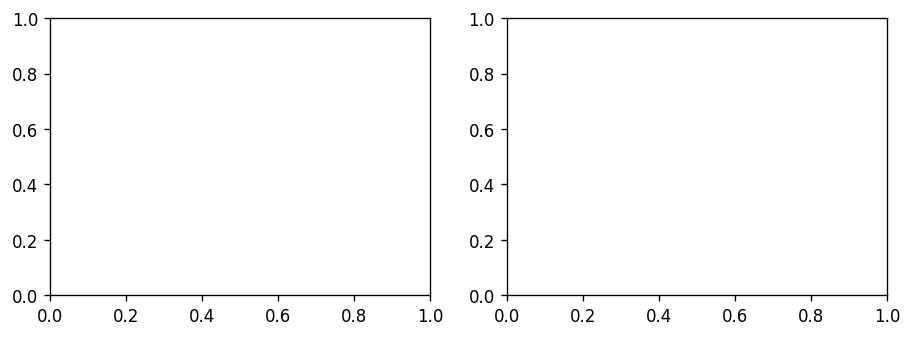

In [10]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

As before, the parameter p is set to 1: p=1

#### Building the ARIMA Model

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,2,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,0))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = simple_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [ ]:
# Forecast the next 10 years
forecast_steps = 10
forecast = simple_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in industry (% of female employment) - China")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

### Employment in services, female (% of female employment) (modeled ILO estimate) - China

In [ ]:
empl_serv_china = female_indicators[
    (female_indicators["Country"] == "China") &
    (female_indicators["Indicator Name"] == "Employment in services, female (% of female employment)")
]

# Prepare the time series
ts = empl_serv_china[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [ ]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

In [ ]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

Since in the second order differencing there is a lag quickly going below zero, it is probably due to over differencing. Therefore, the p will be set to p=1.
It can be checked by calculating the statistics on the differencings.

In [11]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

They clearly show that there is no need for a second differencing, as the ADF is lower than the critical values and the p-value is lower than the significance level when computing the first order differencing.

#### AR (p)

In [12]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

#### MA (q)

NameError: name 'ts_diff' is not defined

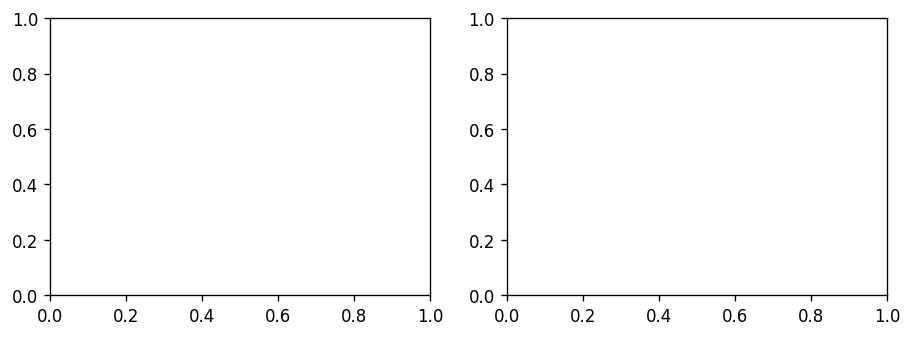

In [13]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

Despite the first two lags being out of the significance line, in order to have a less complicated model, the q will be set to q=1.

#### Building the ARIMA Model

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,0))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = initial_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [ ]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in services (% of female employment) - China")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

### Employment in Agriculture, Industries and Services in India

#### Employment in agriculture, female (% of female employment) (modeled ILO estimate) - India

In [ ]:
empl_agr_india = female_indicators[
    (female_indicators["Country"] == "India") &
    (female_indicators["Indicator Name"] == "Employment in agriculture, female (% of female employment)")
]

# Prepare the time series
ts = empl_agr_india[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [ ]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

As the ADF test results cannot reject the null hypotheses, differencing is needed to make the series stationary.

In [14]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'ts' is not defined

It looks like the series only needed differencing once to be made stationary. Below the results of the new ADF test.

In [15]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

Despite what seen above, apparently two differencings were needed to make the series stationary.

#### AR (p)

In [16]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

Lag 1 is significantly over the significance line. Lag 2 is also above, but let us be more conservative and set p=1.

#### MA (q)

NameError: name 'ts_diff' is not defined

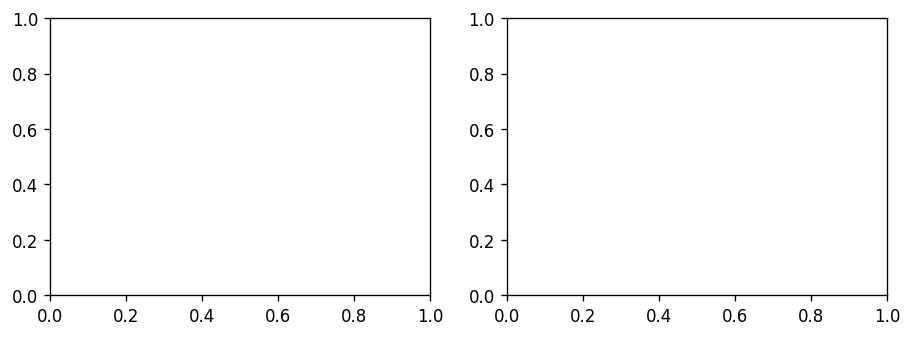

In [17]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

Again, lag 1 is significantly above the limit, thus setting the q=1.

#### Building the ARIMA model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,0))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = initial_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [18]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in agriculture (% of female employment) - India")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'initial_model_fit' is not defined

#### Employment in industry, female (% of female employment) (modeled ILO estimate) - India

In [ ]:
empl_ind_india = female_indicators[
    (female_indicators["Country"] == "India") &
    (female_indicators["Indicator Name"] == "Employment in industry, female (% of female employment)")
]

# Prepare the time series
ts = empl_ind_india[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [19]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

ADF Test for Original Series:


NameError: name 'ts' is not defined

In [20]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'ts' is not defined

In [21]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

#### AR (p)

In [22]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

#### MA (q)

NameError: name 'ts_diff' is not defined

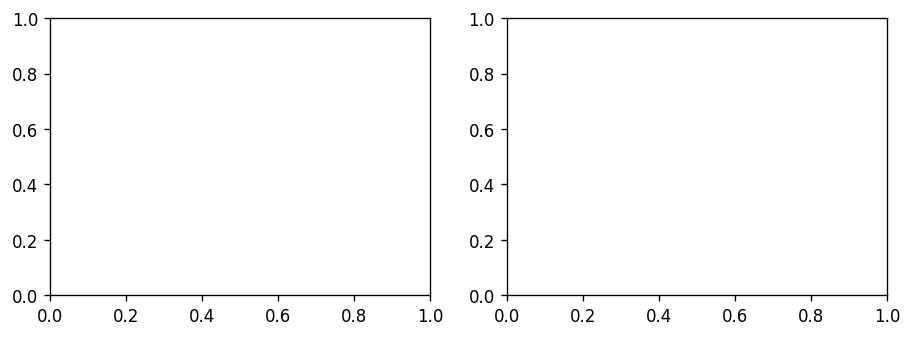

In [23]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

#### Building the ARIMA model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,0))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = simple_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [ ]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in industry (% of female employment) - India")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

### Employment in services, female (% of female employment) (modeled ILO estimate) - India

In [ ]:
empl_serv_india = female_indicators[
    (female_indicators["Country"] == "India") &
    (female_indicators["Indicator Name"] == "Employment in services, female (% of female employment)")
]

# Prepare the time series
ts = empl_serv_india[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [ ]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

In [24]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'ts' is not defined

In [25]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

#### AR (p)

In [26]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

#### MA (q)

NameError: name 'ts_diff' is not defined

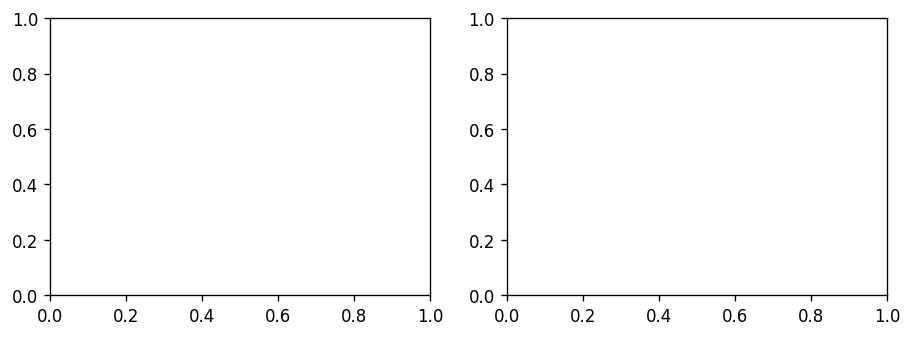

In [27]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

#### Building the ARIMA model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,0))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = initial_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [ ]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in services (% of female employment) - India")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

### Employment in Agriculture, European Union

In [ ]:
empl_agr_eu = female_indicators[
    (female_indicators["Country"] == "European Union") &
    (female_indicators["Indicator Name"] == "Employment in agriculture, female (% of female employment)")
]

# Prepare the time series
ts = empl_agr_eu[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [ ]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

In [ ]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

### AR (p)

In [28]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

### MA (q)

NameError: name 'ts_diff' is not defined

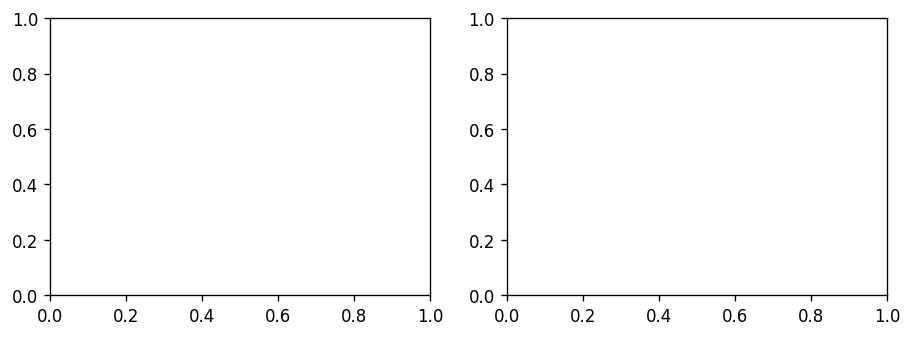

In [29]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

### Building the ARIMA model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = initial_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [30]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in agriculture (% of female employment) - European Union")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'initial_model_fit' is not defined

### Employment in industry, female (% of female employment) - European Union

In [ ]:
empl_ind_eu = female_indicators[
    (female_indicators["Country"] == "European Union") &
    (female_indicators["Indicator Name"] == "Employment in industry, female (% of female employment)")
]

# Prepare the time series
ts = empl_ind_eu[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [31]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

ADF Test for Original Series:


NameError: name 'ts' is not defined

In [32]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'ts' is not defined

In [33]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

#### AR (p)

In [34]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

#### MA (q)

NameError: name 'ts_diff' is not defined

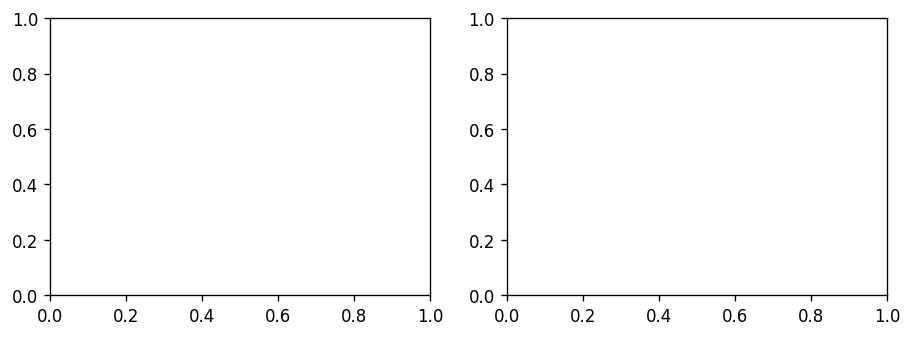

In [35]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

#### Building the ARIMA model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,0))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
residuals = initial_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [36]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in industry (% of female employment) - European Union")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'initial_model_fit' is not defined

### Employment in services, female (% of female employment) - European Union

In [ ]:
empl_serv_eu = female_indicators[
    (female_indicators["Country"] == "European Union") &
    (female_indicators["Indicator Name"] == "Employment in services, female (% of female employment)")
]

# Prepare the time series
ts = empl_serv_eu[["Year", "Indicator Value"]].dropna()
ts["Year"] = ts["Year"].astype(int)
ts["Year"] = pd.to_datetime(ts["Year"], format='%Y').dt.year
ts.set_index("Year", inplace=True)
ts.index = pd.RangeIndex(start=ts.index.min(), stop=ts.index.max() + 1, step=1)

In [37]:
# Check for stationarity in the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))

print("ADF Test for Original Series:")
adf_test(ts['Indicator Value'])

ADF Test for Original Series:


NameError: name 'ts' is not defined

In [38]:
# Autocorrelation
first_year = ts.index.min()
last_year = ts.index.max()

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Original Series
axes[0, 0].plot(ts.index, ts['Indicator Value'], marker='o')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xlim([first_year, last_year])

# Autocorrelation for Original Series
plot_acf(ts['Indicator Value'].dropna(), ax=axes[0, 1])

# 1st Differencing
ts_diff = ts['Indicator Value'].diff().dropna()
axes[1, 0].plot(ts_diff.index, ts_diff, marker='o')
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xlim([first_year, last_year])

# Autocorrelation for 1st Differencing
plot_acf(ts_diff, ax=axes[1, 1])

# 2nd Differencing
ts_diff2 = ts_diff.diff().dropna()
axes[2, 0].plot(ts_diff2.index, ts_diff2, marker='o')
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xlim([first_year, last_year])

# Autocorrelation for 2nd Differencing
plot_acf(ts_diff2, ax=axes[2, 1])

# Rotate x-axis labels for better readability
for ax in axes[:, 0]:
    ax.tick_params(axis='x', rotation=45)

# Make sure ACF plots do not share x-axis settings with time series plots
for ax in axes[:, 1]:
    ax.set_xlim(auto=True)  # Let the ACF plots use their own scaling

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'ts' is not defined

In [39]:
result = adfuller(ts_diff)
print("First order of differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

result_2 = adfuller(ts_diff2)
print("\nSecond order of differencing:")
print(f"ADF Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
for key, value in result_2[4].items():
    print(f"Critical Value ({key}%): {value:.3f}")

NameError: name 'ts_diff' is not defined

#### AR (p)

In [40]:
# Update plot settings for better readability
first_year = ts.index.min()
last_year = ts.index.max()
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# PACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_pacf(ts_diff, ax=axes[1])

plt.show()

NameError: name 'ts' is not defined

#### MA (q)

NameError: name 'ts_diff' is not defined

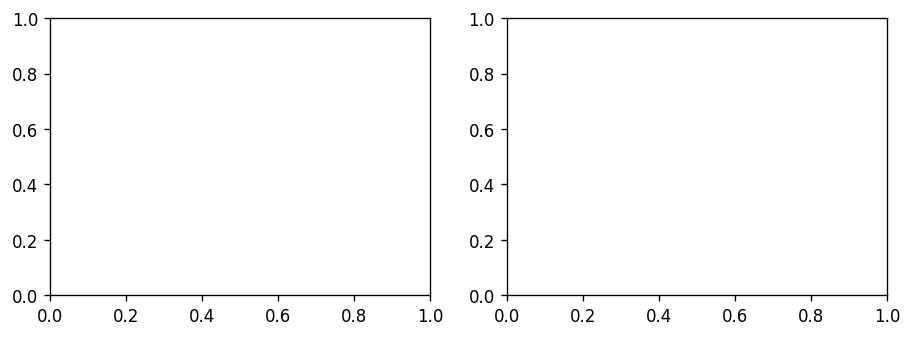

In [41]:
# Update plot settings for better readability
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Create subplots
fig, axes = plt.subplots(1, 2, sharex=False)

# 1st Order Differencing
axes[0].plot(ts_diff.index, ts_diff, marker='o')
axes[0].set_title('1st Differencing')
axes[0].set_xlim([first_year, last_year])

# ACF Plot for First-Order Differencing
axes[1].set(ylim=(-1, 1))
plot_acf(ts_diff, ax=axes[1])
plt.show()

#### Building the ARIMA model ARIMA(p,d,q)

In [ ]:
# Define train-test split size
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

# Split into training and test sets
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

initial_model = ARIMA(ts['Indicator Value'], order=(1,2,1))
initial_model_fit = initial_model.fit()
print("Initial Model Summary:")
print(initial_model_fit.summary())

simple_model = ARIMA(ts['Indicator Value'], order=(1,1,1))
simple_model_fit = simple_model.fit()
print("\nSimpler Model Summary:")
print(simple_model_fit.summary())

In [ ]:
# Forecast the same length as the test set
initial_test_forecast = initial_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], initial_test_forecast)
mse = mean_squared_error(test['Indicator Value'], initial_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("Initial Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Forecast the same length as the test set
simple_test_forecast = simple_model_fit.forecast(steps=len(test))

# Evaluate predictions
mae = mean_absolute_error(test['Indicator Value'], simple_test_forecast)
mse = mean_squared_error(test['Indicator Value'], simple_test_forecast)
rmse = mse ** 0.5

# Print evaluation metrics
print("\nSimple Model Statistics")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [42]:
residuals = simple_model_fit.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

NameError: name 'simple_model_fit' is not defined

In [43]:
# Forecast the next 10 years
forecast_steps = 10
forecast = initial_model_fit.forecast(steps=forecast_steps)

# Create a forecast index starting from the next available year
forecast_index = list(range(ts.index[-1] + 1, ts.index[-1] + 1 + forecast_steps))

# Convert to Series for plotting
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Indicator Value'], label="Historical Data")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast", color="red", marker='o')
plt.title("Female Employment in services (% of female employment) - European Union")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'initial_model_fit' is not defined

### Urbanization and Employment

In [44]:
emp_urb_indicators = [
    'Wage and salaried workers, female (% of female employment)',
    'Wage and salaried workers, male (% of male employment) (modeled ILO estimate)',
    'Contributing family workers, female (% of female employment) (modeled ILO estimate)',
    'Contributing family workers, male (% of male employment) (modeled ILO estimate)',
    'Employers, female (% of female employment) (modeled ILO estimate)',
    'Employers, male (% of male employment) (modeled ILO estimate)',
    'Employment in agriculture, female (% of female employment) (modeled ILO estimate)',
    'Employment in agriculture, male (% of male employment) (modeled ILO estimate)',
    'Employment in industry, female (% of female employment) (modeled ILO estimate)',
    'Employment in industry, male (% of male employment) (modeled ILO estimate)',
    'Employment in services, female (% of female employment) (modeled ILO estimate)',
    'Employment in services, male (% of male employment) (modeled ILO estimate)',
    'Vulnerable employment, male (% of male employment) (modeled ILO estimate)',
    'Vulnerable employment, female (% of female employment) (modeled ILO estimate)',
    'Part time employment, female (% of total female employment)',
    'Part time employment, male (% of total male employment)',
    'Self-employed, female (% of female employment) (modeled ILO estimate)',
    'Self-employed, male (% of male employment) (modeled ILO estimate)',
    'Unemployment, female (% of female labor force) (modeled ILO estimate)',
    'Unemployment, male (% of male labor force) (modeled ILO estimate)',
    'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)',
    'Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)',
    'Urban population (% of total population)',
    'Population in urban agglomerations of more than 1 million (% of total population)'
]

# Filter the data for these specific indicators
emp_urb_data = df[df['Indicator Name'].isin(emp_urb_indicators)]
emp_urb_data['Indicator Name'] = emp_urb_data['Indicator Name'].apply(
    lambda x: x.replace(' (modeled ILO estimate)', '') if ' (modeled ILO estimate)' in x else x
)

emp_urb_data = emp_urb_data[(emp_urb_data['Gender'] == 'Female') | (emp_urb_data['Indicator Name'].isin(['Urban population (% of total population)', 'Population in urban agglomerations of more than 1 million (% of total population)']))]

NameError: name 'df' is not defined

In [45]:
print(emp_urb_data['Indicator Name'].unique())

NameError: name 'emp_urb_data' is not defined

### Correlation

#### China

In [46]:
emp_urb_china_data = emp_urb_data[emp_urb_data['Country'] == 'China']

# Pivot the data to prepare it for correlation calculation
pivot_data = emp_urb_china_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

correlation_matrix_china = pivot_data.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_china, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation Employment vs. Urbanization - China', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'emp_urb_data' is not defined

#### India

In [47]:
emp_urb_india_data = emp_urb_data[emp_urb_data['Country'] == 'India']

# Pivot the data to prepare it for correlation calculation
pivot_data = emp_urb_india_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

correlation_matrix_india = pivot_data.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_india, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation Employment vs. Urbanization - India', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'emp_urb_data' is not defined

#### European Union

In [48]:
emp_urb_eu_data = emp_urb_data[emp_urb_data['Country'] == 'European Union']

# Pivot the data to prepare it for correlation calculation
pivot_data = emp_urb_eu_data.pivot_table(
    index=['Year', 'Country'],
    columns='Indicator Name',
    values='Indicator Value',
    aggfunc=np.mean
).reset_index()

correlation_matrix_eu = pivot_data.drop(columns=['Year']).select_dtypes(include=[np.number]).corr(method="pearson")

# Plot the heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix_eu, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation Employment vs. Urbanization - European Union', fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'emp_urb_data' is not defined